In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
import tensorflow as tf 
import numpy as np
import re
import pandas as pd

import os
import time
import functools

from IPython import display as ipythondisplay
from tqdm import tqdm
from typing import Dict, Optional, List

import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score,f1_score,precision_score,accuracy_score



#Load data

In [4]:
finale_dataframe = pd.read_csv("/content/drive/MyDrive/Newspaper Classification/Data/version_2_26-11-2021.csv",encoding="utf8")
finale_dataframe=finale_dataframe[~finale_dataframe['label'].str.contains("po")]
len(finale_dataframe)

200000

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    finale_dataframe.drop("label", axis=1),
                                                    finale_dataframe["label"], 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    stratify = finale_dataframe["label"]
                                                    )

X_valid, X_test, y_valid, y_test = train_test_split(
                                                    X_test,
                                                    y_test, 
                                                    test_size=0.5, 
                                                    shuffle=True, 
                                                    random_state=42, 
                                                    stratify = y_test
                                                    )
del finale_dataframe

In [6]:
def labelsToIndex(lst):
    label = ["ec","hp","ed","sp","st"]
    ret = []
    for i in range(0,len(lst)):
        mold = [0]*len(label)
        mold[label.index(lst[i])]=1
        ret.append(mold.copy())
    return ret

In [7]:
y_train = labelsToIndex(list(y_train))
y_valid = labelsToIndex(list(y_valid))

In [8]:
def dataframe_to_tfdataset(dataframe,target):
    dataset = tf.data.Dataset.from_tensor_slices((dataframe['data'], target))
    return dataset

In [9]:
train = dataframe_to_tfdataset(X_train,y_train)
valid = dataframe_to_tfdataset(X_valid,y_valid)

In [10]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64
train = train.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid  = valid.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#Building Tokenizers and Models

In [ ]:
vocab = 50000

In [ ]:
def encoder(vocab_size,dataset,length):
    encoder1 = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=vocab_size+2,output_sequence_length=length)
    encoder1.adapt(dataset.map(lambda text, label: text))
    return encoder1

In [ ]:
model_encoder=encoder(vocab,train,1000)


In [ ]:
def Bi_LSTM_model(vocab_size,embed_size,rnn_units,rnn_units_2,encoder):
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding( 
            input_dim=vocab_size,
            output_dim=embed_size,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units_2)),
        tf.keras.layers.Dense(rnn_units, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return model

In [ ]:
model=Bi_LSTM_model(vocab+2,300,64,32,model_encoder)

#Training Model

In [ ]:
checkpoint_path = "/content/drive/MyDrive/Newspaper Classification/Model-without Politics/Stacked_LSTM/checkpoint/"

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                    min_delta=0.0001,
                                    patience = 2),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'Stacked_lstm.{epoch:02d}-{val_loss:.2f}_normal_validation.ckpt',save_weights_only=True),
    tf.keras.callbacks.TensorBoard(checkpoint_path+'logs'),
]

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:

history = model.fit(train, epochs=10,
                    validation_data=valid,batch_size=16,callbacks=my_callbacks)

Epoch 1/10
2500/2500 [==============================] - 1342s 528ms/step - loss: 0.3678 - accuracy: 0.8884 - val_loss: 0.1447 - val_accuracy: 0.9586
Epoch 2/10
2500/2500 [==============================] - 1316s 526ms/step - loss: 0.1221 - accuracy: 0.9695 - val_loss: 0.1041 - val_accuracy: 0.9705
Epoch 3/10
2500/2500 [==============================] - 1316s 526ms/step - loss: 0.0744 - accuracy: 0.9812 - val_loss: 0.0978 - val_accuracy: 0.9733
Epoch 4/10
2500/2500 [==============================] - 1316s 526ms/step - loss: 0.0485 - accuracy: 0.9879 - val_loss: 0.1067 - val_accuracy: 0.9740
Epoch 5/10
2500/2500 [==============================] - 1315s 526ms/step - loss: 0.0331 - accuracy: 0.9916 - val_loss: 0.0924 - val_accuracy: 0.9756
Epoch 6/10
2500/2500 [==============================] - 1314s 525ms/step - loss: 0.0262 - accuracy: 0.9933 - val_loss: 0.0985 - val_accuracy: 0.9761
Epoch 7/10
2500/2500 [==============================] - 1315s 526ms/step - loss: 0.0169 - accuracy: 0.9959

#Load model

In [11]:
vocab = 50000

In [12]:
def encoder(vocab_size,dataset,length):
    encoder1 = tf.keras.layers.experimental.preprocessing.TextVectorization(
        max_tokens=vocab_size+2,output_sequence_length=length)
    encoder1.adapt(dataset.map(lambda text, label: text))
    return encoder1

In [13]:
model_encoder=encoder(vocab,train,1000)


In [14]:
def Bi_LSTM_model(vocab_size,embed_size,rnn_units,rnn_units_2,encoder):
    model = tf.keras.Sequential([
        encoder,
        tf.keras.layers.Embedding( 
            input_dim=vocab_size,
            output_dim=embed_size,
            # Use masking to handle the variable sequence lengths
            mask_zero=True),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units,return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(rnn_units_2)),
        tf.keras.layers.Dense(rnn_units, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])
    return model

In [15]:
model=Bi_LSTM_model(vocab+2,300,64,32,model_encoder)

##Best for validation

In [16]:
model.load_weights("/content/drive/MyDrive/Newspaper Classification/Model-without Politics/Stacked_LSTM/checkpoint/Stacked_lstm.05-0.09_normal_validation.ckpt")

In [17]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(2.5e-5),
              metrics=['accuracy'])

In [25]:
model.evaluate(unseen_test)

79/79 [==============================] - 20s 91ms/step - loss: 0.7830 - accuracy: 0.8209


[0.7830083966255188, 0.8208566904067993]

In [26]:
model.evaluate(train)

2500/2500 [==============================] - 239s 96ms/step - loss: 0.0206 - accuracy: 0.9941


[0.020563483238220215, 0.9940750002861023]

In [27]:
model.evaluate(valid)

313/313 [==============================] - 31s 97ms/step - loss: 0.0924 - accuracy: 0.9756


[0.09240743517875671, 0.975600004196167]

## Best for unseen

In [ ]:
model.load_weights("/content/drive/MyDrive/Newspaper Classification/Model-without Politics/Stacked_LSTM/checkpoint/Stacked_lstm.04-0.18_unseen_5e-5_final.ckpt")

In [ ]:
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(2.5e-5),
              metrics=['accuracy'])

In [ ]:
model.evaluate(unseen_test)

79/79 [==============================] - 30s 195ms/step - loss: 0.3965 - accuracy: 0.8931


[0.39648398756980896, 0.8931145071983337]

In [ ]:
model.evaluate(train)

2500/2500 [==============================] - 508s 197ms/step - loss: 0.0941 - accuracy: 0.9756


[0.09406133741140366, 0.9755749702453613]

In [ ]:
model.evaluate(valid)

313/313 [==============================] - 62s 199ms/step - loss: 0.1306 - accuracy: 0.9643


[0.13057290017604828, 0.9642999768257141]

#Load Unseen text

In [19]:
unseen_text = pd.read_csv("/content/drive/MyDrive/Newspaper Classification/Data/unseen_test_v1_3-12-2021.csv",encoding="utf8")
unseen_text=unseen_text[~unseen_text['label'].str.contains("po")]

unseen_text["data"] = unseen_text["data"].str.replace(r'“', '')
unseen_text = unseen_text.drop_duplicates(subset=['data'],keep=False)
unseen_text = unseen_text.dropna().replace('\n','', regex=True).replace('\xa0',' ', regex=True)
unseen_text = unseen_text.dropna().replace('Chinhphu vn','', regex=True).replace('\s+', ' ', regex=True)
unseen_text = unseen_text.dropna().replace('…','', regex=True).replace('–','', regex=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [20]:
unseen_text["data"] = unseen_text["data"].replace('chinhphu vn','', regex=True)
unseen_text["data"] = unseen_text["data"].replace('vietnamnet','', regex=True)
unseen_text["data"] = unseen_text["data"].replace('vnexpress','', regex=True)

In [21]:
unseen_text

,ID,data,label
0,qua/286177.vgped,thứ_trưởng bộ gd đt bùi_văn ga khẳng_định mục...,ed
1,bo/355584.vgped,bộ gd đt đã hoàn_thành việc xây_dựng chương_t...,ed
2,11/339878.vgped,từ câu của đề thi bắt_đầu có sự phân_hoá tức_l...,ed
3,hoc/407705.vgped,thông_tư số tt bgdđt ban_hành điều_lệ trường t...,ed
4,ngoai/297920.vgped,dự_thảo nghị_định này quy_định về hợp_tác đầu_...,ed
...,...,...,...
4995,20210605224733948sp,cristiano ronaldo bồ_đào_nha robert lewandowsk...,sp
4996,20210706094818801sp,nóng ở trung_tuyến nhờ sự xuất_sắc của bộ ba t...,sp
4997,20210703032026173sp,anh hơn hẳn ukraine ở các chỉ_số kiểm_soát bón...,sp
4998,20210628013737271sp,đối_đầu với ch czech tại vòng đội tối hà_lan đ...,sp


In [22]:
unseen_label = labelsToIndex(list(unseen_text["label"]))

In [23]:
unseen_test = dataframe_to_tfdataset(unseen_text,unseen_label)

In [24]:
unseen_test  = unseen_test.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [28]:
res = model.predict(list(unseen_text["data"] ))

In [29]:
type(res)

numpy.ndarray

In [30]:
result = np.argmax(res, axis=1)

In [31]:
def indexToRes(result):
    res = list(result)
    label = ["ec","hp","ed","sp","st"]
    ret = []
    for i in range(0,len(res)):
        ret.append(label[int(res[i])])
    return ret

In [32]:
labeled_res = indexToRes(result)
true_res = labelsToIndex(list(unseen_text["label"]))
pred_res = labelsToIndex(labeled_res)


In [33]:
with open("mislabelled.txt","w") as f:
    true_res = list(unseen_text["label"])
    for i in range(0,len(true_res)):
        if (labeled_res[i]!=true_res[i]):
            f.write(str(unseen_text["data"].iloc[i])+","+str(labeled_res[i])+","+true_res[i]+"\n")

In [34]:
print(f1_score(labeled_res,true_res,average="macro"))
print(f1_score(labeled_res,true_res,average="micro"))
print(f1_score(labeled_res,true_res,average="weighted"))
print(accuracy_score(labeled_res,true_res))

0.8227457448175443
0.8208566853482786
0.8189424461463262
0.8208566853482786


In [35]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labeled_res,unseen_text["label"],labels=["ec","hp","ed","sp","st"])

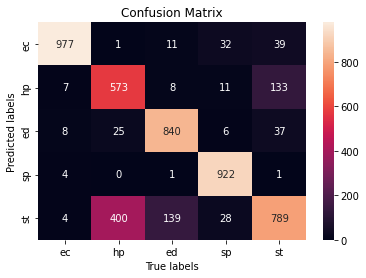

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(["ec","hp","ed","sp","st"]); ax.yaxis.set_ticklabels(["ec","hp","ed","sp","st"]);

In [37]:
lens = [len(x["data"].split(" ")) for _,x in finale_dataframe.iterrows()]
print(np.mean(lens))
plt.hist(lens, bins = list(range(0, 2000,50)))

NameError: ignored